In [1]:
# Import GeneralPackages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
import warnings
import random
from scipy.stats import reciprocal
from PIL import Image
import cv2 # install opencv, if you don't already have it (https://pypi.org/project/opencv-python/)
import pandas as pd
import joblib

# Import Sklearn Packages
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

In [2]:
# Import Tensorflow packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

# Problem 1 - Flower Species Classification

In [3]:
# Define Class Names
class_names = ['Roses', 'Magnolias', 'Lilies', 'Sunflowers', 'Orchids', 
               'Marigold', 'Hibiscus', 'Firebush', 'Pentas', 'Bougainvillea']

In [4]:
# Loading Training Data
X_train = np.load('flower_species_classification/data_train.npy').T
t_train = np.load('flower_species_classification/labels_train.npy')

# Load Test Data
X_test = np.load('flower_species_classification/data_test.npy').T
t_test = np.load('flower_species_classification/labels_test.npy')

print(X_train.shape, t_train.shape)

(1658, 270000) (1658,)


In [5]:
# Perform Stratified Test Train Split
X_training, X_val, t_training, t_val = train_test_split(X_train,
                                                          t_train,
                                                          shuffle=True,
                                                          stratify=t_train,
                                                          test_size=0.20,
                                                       random_state = 42)
print(f"X_training Shape: {X_training.shape}")
print(f"X_val Shape: {X_val.shape}")

X_training Shape: (1326, 270000)
X_val Shape: (332, 270000)


In [6]:
# Scale Data
scaler = MinMaxScaler()
X_training = scaler.fit_transform(X_training)
X_val = scaler.fit_transform(X_val)

# Reshape Image array to accomodate Neural Network
X_train_rs = X_training.reshape([1326,300,300,3])
X_val_rs = X_val.reshape([332,300,300,3])
print(X_train_rs.shape)
print(X_val_rs.shape)

(1326, 300, 300, 3)
(332, 300, 300, 3)


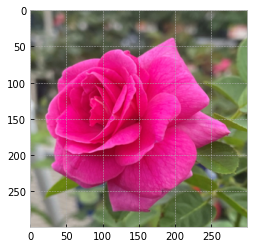

In [7]:
plt.imshow(X_train_rs[0])

## Xception Model

In [7]:
# Import Xception CNN Model
base_model = keras.applications.Xception(weights='imagenet', # Load weights pre-trained on ImageNet.
                                         input_shape=(150, 150, 3),
                                         include_top=False)

2022-12-09 18:07:18.295757: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 18:07:18.824130: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79111 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:b7:00.0, compute capability: 8.0


#### Base Model

In [8]:
# Define Base Model: Xception Weights are not Trainable
base_model.trainable = False

IMG_SIZE = 150 # Xception Image Size
inputs = keras.Input(shape=(300, 300, 3)) # Input Image Size from Flower Data
inputs_resized = keras.layers.Resizing(IMG_SIZE, IMG_SIZE)(inputs) # 150-150-3 # Input layer
x = base_model(inputs_resized, training=False) # resizing input to match pretrained model
x_pooling = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(10, activation='softmax')(x_pooling) # Output Layer
model_Base = tf.keras.Model(inputs, outputs)

# Summary of Model Layers and Parameters
model_Base.summary()

warnings.filterwarnings('ignore')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 20,881,970
Trainable params: 20,490
Non-trainable params: 20,861,480
____________________________________________

In [10]:
# Compile Base Model
model_Base.compile(optimizer=keras.optimizers.Nadam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Fit Base Model to Training Data
model_Base.fit(X_train_rs,t_training, epochs=50, batch_size=32,
          validation_data=(X_val_rs, t_val),
          callbacks=[keras.callbacks.EarlyStopping(patience=10)])

warnings.filterwarnings("ignore")

Epoch 1/50
42/42 [==============================] - 3s 36ms/step - loss: 0.4676 - accuracy: 0.8876 - val_loss: 0.6016 - val_accuracy: 0.8072
Epoch 2/50
42/42 [==============================] - 1s 26ms/step - loss: 0.3894 - accuracy: 0.9103 - val_loss: 0.5486 - val_accuracy: 0.8283
Epoch 3/50
42/42 [==============================] - 1s 26ms/step - loss: 0.3333 - accuracy: 0.9276 - val_loss: 0.5216 - val_accuracy: 0.8343
Epoch 4/50
42/42 [==============================] - 1s 27ms/step - loss: 0.2901 - accuracy: 0.9367 - val_loss: 0.4981 - val_accuracy: 0.8404
Epoch 5/50
42/42 [==============================] - 1s 29ms/step - loss: 0.2599 - accuracy: 0.9487 - val_loss: 0.4849 - val_accuracy: 0.8373
Epoch 6/50
42/42 [==============================] - 1s 29ms/step - loss: 0.2290 - accuracy: 0.9570 - val_loss: 0.4637 - val_accuracy: 0.8434
Epoch 7/50
42/42 [==============================] - 1s 27ms/step - loss: 0.2092 - accuracy: 0.9638 - val_loss: 0.4567 - val_accuracy: 0.8464
Epoch 8/50
42

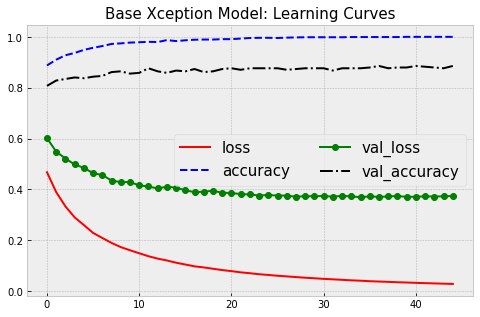

In [12]:
# Display Learning Curve for Train and Validation Data of the Standard Xception Model
key_names = list(model_Base.history.history.keys())
colors = ['-r','--b','-og','-.k']
plt.figure(figsize=(8,5))
for i in range(len(key_names)):
    plt.plot(model_Base.history.history[key_names[i]], colors[i], label=key_names[i])
    plt.legend(fontsize=15,ncol=2)
    plt.title('Base Xception Model: Learning Curves', size=15);

#### Fine-Tuning Modified Xception Model

In [7]:
# Function For Establishing Transfer Learning Model with Tunable Parameters
def create_model(train_layer, LR):
    # Import Xception Model
    base_model = keras.applications.Xception(weights='imagenet', # Load weights pre-trained on ImageNet.
                                         input_shape=(150, 150, 3),
                                         include_top=False)
    # Xception Weights are Trainable
    base_model.trainable = True

    # Let's take a look to see how many layers are in the base model
#     print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = train_layer

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    IMG_SIZE = 150 # Xception Default Image Size
    inputs = keras.Input(shape=(300, 300, 3)) # Input Image Size from Flowers Dataset

    inputs_resized = keras.layers.Resizing(IMG_SIZE, IMG_SIZE)(inputs) # 150-150-3 # Input layer
    x = base_model(inputs_resized, training=False) # resizing input to match pretrained model
    x_pooling = keras.layers.GlobalAveragePooling2D()(x)
    batch = keras.layers.BatchNormalization()(x_pooling)
    outputs = keras.layers.Dense(10, activation='softmax')(batch) # Output Layer
    model = tf.keras.Model(inputs, outputs)
    
    # Compile Model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate = LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Hyperparameter Values to be tuned
tuning_layer = [80, 100,130]
batch_size = [16,32, 40]
LR = [0.001, 0.0001]

# Performs Random CV Search On hyperparameters
for i in range(8):
    tl = random.choice(tuning_layer)
    bs = random.choice(batch_size)
    lr = random.choice(LR)
    
    # Establish Model With randomized hyperparameter Values
    keras_clf = KerasClassifier(build_fn = lambda: create_model(train_layer = tl, LR = lr),
                                epochs = 10, 
                                batch_size = bs,
                               verbose = 0)
                                
                                    
    # Perform Cross Validation Scoring on Model                            
    score = cross_val_score(keras_clf, X_train_rs, t_training, cv=2, scoring='accuracy')
    print(f"Tuning Layer: {tl} | Batch Size: {bs} | Learning Rate {lr}")
    print(f"CV Score: {score.mean()}\n")


/scratch/local/53498934/ipykernel_120167/3918662170.py:40: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  keras_clf = KerasClassifier(build_fn = lambda: create_model(train_layer = tl, LR = lr),
2022-12-09 16:15:29.805760: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 16:15:30.344991: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79111 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:bd:00.0, compute capability: 8.0
2022-12-09 16:15:35.428136: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-12-09 1

Tuning Layer: 100 | Batch Size: 32 | Learning Rate 0.0001
CV Score: 0.8725490196078431



/scratch/local/53498934/ipykernel_120167/3918662170.py:40: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  keras_clf = KerasClassifier(build_fn = lambda: create_model(train_layer = tl, LR = lr),


Tuning Layer: 130 | Batch Size: 16 | Learning Rate 0.001
CV Score: 0.8220211161387632



/scratch/local/53498934/ipykernel_120167/3918662170.py:40: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  keras_clf = KerasClassifier(build_fn = lambda: create_model(train_layer = tl, LR = lr),


Tuning Layer: 130 | Batch Size: 40 | Learning Rate 0.0001
CV Score: 0.641025641025641



/scratch/local/53498934/ipykernel_120167/3918662170.py:40: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  keras_clf = KerasClassifier(build_fn = lambda: create_model(train_layer = tl, LR = lr),


Tuning Layer: 130 | Batch Size: 40 | Learning Rate 0.001
CV Score: 0.8076923076923077



/scratch/local/53498934/ipykernel_120167/3918662170.py:40: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  keras_clf = KerasClassifier(build_fn = lambda: create_model(train_layer = tl, LR = lr),


Tuning Layer: 100 | Batch Size: 40 | Learning Rate 0.001
CV Score: 0.603318250377074



/scratch/local/53498934/ipykernel_120167/3918662170.py:40: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  keras_clf = KerasClassifier(build_fn = lambda: create_model(train_layer = tl, LR = lr),


Tuning Layer: 130 | Batch Size: 32 | Learning Rate 0.0001
CV Score: 0.691553544494721



/scratch/local/53498934/ipykernel_120167/3918662170.py:40: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  keras_clf = KerasClassifier(build_fn = lambda: create_model(train_layer = tl, LR = lr),


Tuning Layer: 130 | Batch Size: 32 | Learning Rate 0.0001
CV Score: 0.6704374057315233



/scratch/local/53498934/ipykernel_120167/3918662170.py:40: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  keras_clf = KerasClassifier(build_fn = lambda: create_model(train_layer = tl, LR = lr),


Tuning Layer: 80 | Batch Size: 16 | Learning Rate 0.001
CV Score: 0.8438914027149321



#### Final Model

In [13]:
warnings.filterwarnings('ignore')
# Final Model as determined by random CV Search

# Model Weights are Trainable
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

IMG_SIZE = 150 # Xception Defaulkt Image Size
inputs = keras.Input(shape=(300, 300, 3)) # Input Image Size

inputs_resized = keras.layers.Resizing(IMG_SIZE, IMG_SIZE)(inputs) # 150-150-3 # Input layer
x = base_model(inputs_resized, training=False) # resizing input to match pretrained model
x_pooling = keras.layers.GlobalAveragePooling2D()(x)
batch = keras.layers.BatchNormalization()(x_pooling)
outputs = keras.layers.Dense(10, activation='softmax')(batch) # Output Layer
model_final = tf.keras.Model(inputs, outputs)

model_final.summary()

warnings.filterwarnings("ignore")

Number of layers in the base model:  132
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 resizing_1 (Resizing)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)  

In [14]:
# Compile Final Model
model_final.compile(optimizer=keras.optimizers.Nadam(learning_rate = 0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Fit Final Model
model_final.fit(X_train_rs,t_training, epochs=100, batch_size=32,
          validation_data=(X_val_rs, t_val),
          callbacks=[keras.callbacks.EarlyStopping(patience=10)])

warnings.filterwarnings("ignore")

Epoch 1/100
42/42 [==============================] - 6s 64ms/step - loss: 1.2261 - accuracy: 0.6124 - val_loss: 0.8932 - val_accuracy: 0.7831
Epoch 2/100
42/42 [==============================] - 2s 40ms/step - loss: 0.2448 - accuracy: 0.9359 - val_loss: 0.5993 - val_accuracy: 0.8524
Epoch 3/100
42/42 [==============================] - 2s 39ms/step - loss: 0.0743 - accuracy: 0.9940 - val_loss: 0.4392 - val_accuracy: 0.8916
Epoch 4/100
42/42 [==============================] - 2s 38ms/step - loss: 0.0247 - accuracy: 1.0000 - val_loss: 0.3495 - val_accuracy: 0.9006
Epoch 5/100
42/42 [==============================] - 2s 38ms/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.3174 - val_accuracy: 0.9157
Epoch 6/100
42/42 [==============================] - 2s 38ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.3074 - val_accuracy: 0.9096
Epoch 7/100
42/42 [==============================] - 2s 38ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.2831 - val_accuracy: 0.9127
Epoch 

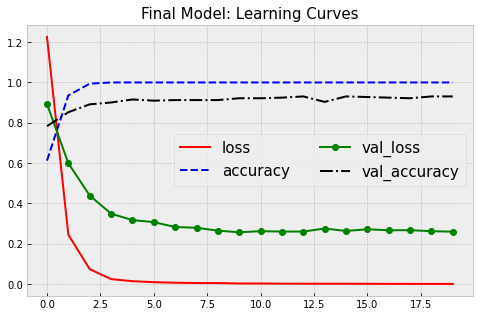

In [15]:
# Display Learning Curve for Train and Validation Data
key_names = list(model_final.history.history.keys())
colors = ['-r','--b','-og','-.k']
plt.figure(figsize=(8,5))
for i in range(len(key_names)):
    plt.plot(model_final.history.history[key_names[i]], colors[i], label=key_names[i])
    plt.legend(fontsize=15,ncol=2)
    plt.title('Final Model: Learning Curves', size=15);

In [11]:
# Save Final Model File
model_final.save('flower_model.h5')

---

---

# Problem 2: Car Detection

In [3]:
# Displays Learning Curve for Train and Validation Data
def LearningCurve(model):
    key_names = list(model.history.history.keys())
    colors = ['-r','--b','-og','-.k']
    plt.figure(figsize=(8,5))
    for i in range(len(key_names)):
        plt.plot(model.history.history[key_names[i]], colors[i], label=key_names[i])
        plt.legend(fontsize=15,ncol=2)
        plt.title('Final Model: Learning Curves', size=15);

In [4]:
# Training Data with Cars in them and associated bounding boxes
bbox = pd.read_csv('car_detection_dataset/train_bounding_boxes.csv')
bbox

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


#### Classification Neural Network

In [5]:
from PIL import Image
import glob

# Extracts Image Number from training data with Cars
train_car = np.zeros([len(bbox)])
for i in range(len(bbox)):
    
    # Extracts XXXXX value from 'vid_4_XXXXX.jpg' file name
    file_name = bbox['image'][i]
    position1= file_name.index('4_')
    position2=file_name.index('.')
    file_number= file_name[position1+2:position2]
    train_car[i] = file_number # XXXXX Value for all Training images with cars


# Extract all Training Images with associated Image Number
train_all = []
image_list = []
# Extracts ALL training images
for file_name in glob.glob('car_detection_dataset/training_images/*.jpg'):
    
    # Extracts XXXXX value from 'vid_4_XXXXX.jpg' file name
    
    position1= file_name.index('4_')
    position2=file_name.index('.')
    file_number= file_name[position1+2:position2]
    train_all.append(file_number) # XXXXX Value for ALL Training images
    
    im=np.array(Image.open(file_name)).flatten()
    image_list.append(im) # ALL Training images in the form of a flattened array

image_list = np.array(image_list)

# Define whether or not image has car
training_all = np.zeros([len(train_all), 2])
training_all[:,0] = train_all
for i in range(len(train_car)):
    car = np.where(train_car[i] == training_all[:,0])
    training_all[car,1] = 1
training_all = training_all.astype(int) # 2 column array specifying XXXXX value for all training samples and 0 or 1 if car is present

In [8]:
print(training_all)
print(image_list.shape)
joblib.dump(training_all, 'training_all.pkl')
joblib.dump(image_list, 'image_list.pkl')

[[13800     1]
 [ 4100     0]
 [10520     1]
 ...
 [26160     0]
 [18440     0]
 [ 7220     0]]
(1001, 770640)


['image_list.pkl']

In [7]:
# Stratified Train Test Split Training Data
X_training, X_val, t_training, t_val = train_test_split(image_list,
                                                          training_all[:,1],
                                                          shuffle=True,
                                                          test_size=0.2,
                                                        stratify = training_all[:,1],
                                                       random_state = 42)
print(f"X_training Shape: {X_training.shape}")
print(f"X_val Shape: {X_val.shape}")

X_training Shape: (800, 770640)
X_val Shape: (201, 770640)


In [8]:
# Scale Training Data
scaler = MinMaxScaler()
X_training = scaler.fit_transform(X_training)
X_val = scaler.transform(X_val)

# Reshape Images to Accomodate Neural Network
X_train_rs = X_training.reshape(800,380,676,3)
X_val_rs = X_val.reshape(201,380,676,3)

In [9]:
# Import MobileNetV2 Transfer Learning Model
CNN_model = tf.keras.applications.MobileNetV2(weights = "imagenet",
                                             input_shape=(224, 224, 3),
                                             include_top=False)

# Model Weights Are Trainable
CNN_model.trainable = True

# Let's take a look to see how many layers are in the base model

# Fine-tune from this layer onwards
fine_tune_at = 224

# Freeze all the layers before the `fine_tune_at` layer
for layer in CNN_model.layers[:fine_tune_at]:
    layer.trainable = False


IMG_SIZE = 224 # MobileNetV2 Default Image Size
inputs = keras.Input(shape=(380, 676, 3)) # Input Image Size
inputs_resized = keras.layers.Resizing(IMG_SIZE, IMG_SIZE)(inputs) # 150-150-3 # Input layer
x = CNN_model(inputs_resized, training=False) # resizing input to match pretrained model
x_pooling = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(2, activation='softmax')(x_pooling) # Output Layer
model_MNV2 = tf.keras.Model(inputs, outputs)

# Model Summary
model_MNV2.summary()

warnings.filterwarnings('ignore')

2022-12-10 01:52:00.859116: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 01:52:01.284448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79111 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 380, 676, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable

In [ ]:
# Hyperparameter Values Tested
# *Note: When running GridSearchCV, RandomSearchCV, and iterative tuning with for-loops, the kerenel
# would crash, due to memory limitations. The following hyperparameters were, therefore, implemented manually
# and evaluated based on the MSE of the validation set.
# batch_size [16, 32, 48]
# tuning_layer = [50, 100, 224] # Transfer learning layer to begin retraining weights

In [10]:
# Compile Car Classification Model
model_MNV2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Fit Car Classification
model_MNV2.fit(X_train_rs,t_training, epochs=20, batch_size=32,
          validation_data=(X_val_rs, t_val),
          callbacks=[keras.callbacks.EarlyStopping(patience=10)])

warnings.filterwarnings("ignore")

Epoch 1/20


2022-12-10 01:52:10.998681: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-12-10 01:52:12.037517: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2022-12-10 01:52:12.223081: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


 5/25 [=====>........................] - ETA: 0s - loss: 0.9157 - accuracy: 0.5562

2022-12-10 01:52:13.165498: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


25/25 [==============================] - 7s 115ms/step - loss: 0.6294 - accuracy: 0.7100 - val_loss: 0.3834 - val_accuracy: 0.8358
Epoch 2/20
25/25 [==============================] - 2s 63ms/step - loss: 0.3325 - accuracy: 0.8737 - val_loss: 0.3195 - val_accuracy: 0.8905
Epoch 3/20
25/25 [==============================] - 2s 62ms/step - loss: 0.2764 - accuracy: 0.8950 - val_loss: 0.2934 - val_accuracy: 0.8856
Epoch 4/20
25/25 [==============================] - 2s 62ms/step - loss: 0.2551 - accuracy: 0.8925 - val_loss: 0.2663 - val_accuracy: 0.9104
Epoch 5/20
25/25 [==============================] - 2s 62ms/step - loss: 0.2287 - accuracy: 0.9112 - val_loss: 0.2566 - val_accuracy: 0.9005
Epoch 6/20
25/25 [==============================] - 2s 63ms/step - loss: 0.2120 - accuracy: 0.9150 - val_loss: 0.2531 - val_accuracy: 0.9005
Epoch 7/20
25/25 [==============================] - 2s 68ms/step - loss: 0.1994 - accuracy: 0.9200 - val_loss: 0.2297 - val_accuracy: 0.9154
Epoch 8/20
25/25 [=====

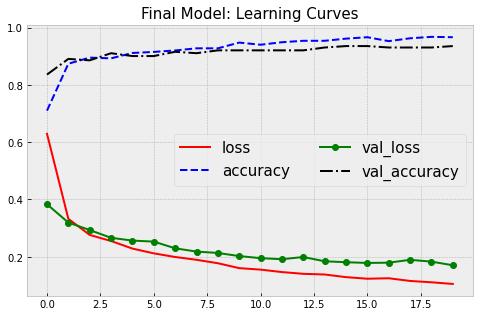

In [11]:
# Learning Curve for Tuned MobileNetV2 Classification Model
LearningCurve(model_MNV2)

In [18]:
model_MNV2.save('car_clf_model.h5')

#### Bounding Box Neural Network

In [5]:
N = len(bbox) # no. of training samples

# Create a numpy array with all images
for i in range(N): 
    filename='car_detection_dataset/training_images/'+bbox['image'][i]
    image = np.array(Image.open(filename))
    image_col = image.ravel()[:,np.newaxis]
    
    if i==0:
        X_train = image_col
    else:
        X_train = np.hstack((X_train, image_col))

# Training feature matrices
X_train = X_train.T

# Training labels
t_train = bbox.drop('image', axis=1).round().to_numpy().astype(int)

X_train.shape, t_train.shape

((559, 770640), (559, 4))

In [6]:
# Test Train Split of Training Data
X_training, X_val, t_training, t_val = train_test_split(X_train,
                                                          t_train,
                                                          shuffle=True,
                                                          test_size=0.2,
                                                       random_state = 42)
print(f"X_training Shape: {X_training.shape}")
print(f"X_val Shape: {X_val.shape}")

X_training Shape: (447, 770640)
X_val Shape: (112, 770640)


In [7]:
# Performs Scaling on Training and Validation Data
scaler = MinMaxScaler()
X_training = scaler.fit_transform(X_training)
X_val = scaler.transform(X_val)

# Reshape Data to Accomodate Neural Network
X_train_rs = X_training.reshape(447,380,676,3)
X_val_rs = X_val.reshape(112,380,676,3)

In [8]:
# Object Detection Nueral Network
from keras.layers import Dense, Activation, Flatten

# Object detection: Bounding box regression with Keras, TensorFlow, and Deep Learning
box_model = tf.keras.applications.MobileNetV2(weights = "imagenet",
                                             input_shape=(224, 224, 3),
                                             include_top=False)

box_model.trainable = True

# Let's take a look to see how many layers are in the base model

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in box_model.layers[:fine_tune_at]:
    layer.trainable = False

IMG_SIZE = 224 # MobileNetV2 default Image Size
inputs = keras.Input(shape=(380, 676, 3)) # Input Image Size
inputs_resized = keras.layers.Resizing(IMG_SIZE, IMG_SIZE)(inputs) # 150-150-3 # Input layer
x = box_model(inputs_resized, training=False)

flatten = Flatten()(x)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="softplus")(bboxHead) # ouputs regression values for bounding box verticies
model = tf.keras.Model(inputs=inputs, outputs=bboxHead)

model.summary()

2022-12-10 13:45:09.102530: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 13:45:09.628683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79111 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4e:00.0, compute capability: 8.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 380, 676, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                             

In [ ]:
# Hyperparameter Values Tested
# *Note: When running GridSearchCV, RandomSearchCV, and iterative tuning with for-loops, the kerenel
# would crash, due to memory limitations. The following hyperparameters were, therefore, implemented manually
# and evaluated based on the MSE of the validation set. First, a manually tuned model is shown, then the final model
# given the best hyperparameters
# batch_size [16, 32, 48]
# epochs = [25, 50, 75]
# tuning_layer = [50, 100, 120] # Transfer learning layer to begin retraining weights

In [12]:
# Example of tuning model using various hyperparameters (tested manually)
opt = optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss="mse", optimizer=opt, metrics=keras.metrics.MeanSquaredError())
# train the network for bounding box regression
model.fit(X_train_rs,
          t_training,
          validation_data=(X_val_rs, t_val),
          batch_size=16,
          epochs=50,
          verbose=1)

Epoch 1/50
28/28 [==============================] - 4s 81ms/step - loss: 30399.3691 - mean_squared_error: 30399.3691 - val_loss: 20539.4980 - val_mean_squared_error: 20539.4980
Epoch 2/50
28/28 [==============================] - 1s 39ms/step - loss: 23534.6738 - mean_squared_error: 23534.6738 - val_loss: 20244.6289 - val_mean_squared_error: 20244.6289
Epoch 3/50
28/28 [==============================] - 1s 39ms/step - loss: 23087.6582 - mean_squared_error: 23087.6582 - val_loss: 19653.5645 - val_mean_squared_error: 19653.5645
Epoch 4/50
28/28 [==============================] - 1s 39ms/step - loss: 24672.6250 - mean_squared_error: 24672.6250 - val_loss: 21303.4219 - val_mean_squared_error: 21303.4219
Epoch 5/50
28/28 [==============================] - 1s 39ms/step - loss: 25026.5684 - mean_squared_error: 25026.5684 - val_loss: 19875.7656 - val_mean_squared_error: 19875.7656
Epoch 6/50
28/28 [==============================] - 1s 39ms/step - loss: 24916.1133 - mean_squared_error: 24916.113

In [9]:
# Tuned Model using optimal hyperparameters (tested manually)
opt = optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss="mse", optimizer=opt, metrics=keras.metrics.MeanSquaredError())
# train the network for bounding box regression
model.fit(X_train_rs,
          t_training,
          validation_data=(X_val_rs, t_val),
          batch_size=32,
          epochs=75,
          verbose=1)

Epoch 1/75


2022-12-10 13:45:21.583474: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-12-10 13:45:22.696277: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2022-12-10 13:45:22.892245: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-12-10 13:45:23.873933: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 [==============================] - 8s 182ms/step - loss: 46571.1758 - mean_squared_error: 46571.1758 - val_loss: 20476.7402 - val_mean_squared_error: 20476.7402
Epoch 2/75
14/14 [==============================] - 1s 69ms/step - loss: 23025.8066 - mean_squared_error: 23025.8066 - val_loss: 20013.0820 - val_mean_squared_error: 20013.0820
Epoch 3/75
14/14 [==============================] - 1s 67ms/step - loss: 21624.5410 - mean_squared_error: 21624.5410 - val_loss: 18928.7363 - val_mean_squared_error: 18928.7363
Epoch 4/75
14/14 [==============================] - 1s 68ms/step - loss: 20879.5938 - mean_squared_error: 20879.5938 - val_loss: 18442.3145 - val_mean_squared_error: 18442.3145
Epoch 5/75
14/14 [==============================] - 1s 79ms/step - loss: 19491.4766 - mean_squared_error: 19491.4766 - val_loss: 18202.5371 - val_mean_squared_error: 18202.5371
Epoch 6/75
14/14 [==============================] - 1s 70ms/step - loss: 16284.7568 - mean_squared_error: 16284.7568 - val_lo

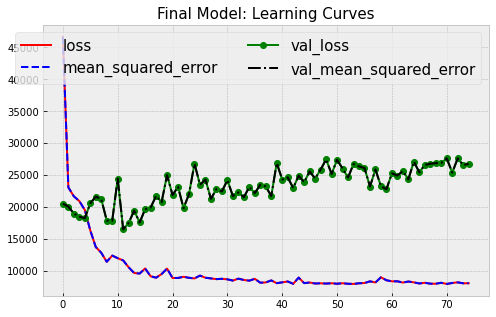

In [10]:
# Learning Curve for Bounding Box Detection Model
LearningCurve(model)

In [11]:
model.save('car_clf_box.h5')

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
